In [1]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [2]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2596 (20.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2162 (17.1%) Users that have less than 1 test interactions


In [3]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([32, 34,  3, ...,  6, 21, 51], dtype=int32), (12638,))

In [4]:
block_size = int(len(profile_length)*0.2)
block_size

2527

In [5]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 2527, average p.len 1.62, median 1.0, min 0, max 3
Group 1, #users in group 2527, average p.len 6.17, median 6.0, min 3, max 10
Group 2, #users in group 2527, average p.len 14.73, median 14.0, min 10, max 21
Group 3, #users in group 2527, average p.len 31.83, median 31.0, min 21, max 46
Group 4, #users in group 2527, average p.len 96.28, median 75.0, min 46, max 554


In [6]:
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   #"NMF": NMFRecommender,
                                   #"BPR": MatrixFactorization_BPR_Cython,
                                   "SLIM_ELASTIC": SLIMElasticNetRecommender,
                                   #"LightFM": LightFMCFRecommender,
                                   #"IALS": IALSRecommender,
                                   #"EASE_R": EASE_R_Recommender,
                                   #"HYBRID": HybridRecommender
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].fit()
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)
recommender_object_dict["PureSVD"].fit(num_factors=70, random_seed=42)
#recommender_object_dict["NMF"].load_model("result_experiments/", "NMFRecommender_best_model.zip")
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3beta"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["UserKNNCF"].fit(topK=529, shrink=45, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF')
recommender_object_dict["ItemKNNCF"].fit(topK=22, shrink=6431, similarity='tversky', normalize=True,
                                       feature_weighting='BM25')
#recommender_object_dict["BPR"].load_model("result_experiments/", "MatrixFactorization_BPR_Cython_Recommender_best_model.zip")
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
#recommender_object_dict["IALS"].fit()
#recommender_object_dict["EASE_R"].load_model("result_experiments_old/", "EASE_R_Recommender_best_model.zip")
#recommender_object_dict["HYBRID"].fit()
from Hybrid import LinearHybridRecommender
#recommenders = [SLIM_Elastic, RP3Beta, ItemKNNCF, UserKNNCF] # ORDER MATTER!!!!!!!!!

#alphas = [0.6321191861151624, 1.390285841050952, 0.23173069155212617, 0.0031112219228564527]

#recommender_object_dict["HYBRID"] = LinearHybridRecommender(URM_train, recommenders)
#recommender_object_dict["HYBRID"].fit(alphas)

TopPopRecommender: URM Detected 213 ( 1.7%) users with no interactions.
TopPopRecommender: URM Detected 128 ( 0.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 213 ( 1.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 128 ( 0.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 213 ( 1.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 128 ( 0.6%) items with no interactions.
RP3betaRecommender: URM Detected 213 ( 1.7%) users with no interactions.
RP3betaRecommender: URM Detected 128 ( 0.6%) items with no interactions.
PureSVDRecommender: URM Detected 213 ( 1.7%) users with no interactions.
PureSVDRecommender: URM Detected 128 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 213 ( 1.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 128 ( 0.6%) items with no interactions.
SLIMElasticNetRecommender: Processed 15888 (71.5%) in 5.00 min. Items per second: 52.96
SLIMElasticNetRe

In [7]:
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 5):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 2527, average p.len 1.62, median 1.0, min 0, max 3
EvaluatorHoldout: Ignoring 2162 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10111 Users
EvaluatorHoldout: Processed 1123 (100.0%) in 0.80 sec. Users per second: 1396
EvaluatorHoldout: Processed 1123 (100.0%) in 0.91 sec. Users per second: 1232
EvaluatorHoldout: Processed 1123 (100.0%) in 0.88 sec. Users per second: 1274
EvaluatorHoldout: Processed 1123 (100.0%) in 0.84 sec. Users per second: 1342
EvaluatorHoldout: Processed 1123 (100.0%) in 0.98 sec. Users per second: 1144
EvaluatorHoldout: Processed 1123 (100.0%) in 0.85 sec. Users per second: 1325
Group 1, #users in group 2527, average p.len 6.17, median 6.0, min 3, max 10
EvaluatorHoldout: Ignoring 2162 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 10111 Users
EvaluatorHoldout: Processed 1899 (100.0%) in 1.23 sec. Users per second: 1546
EvaluatorHoldout: Processed 1899 (100.0%) in 1.51 s

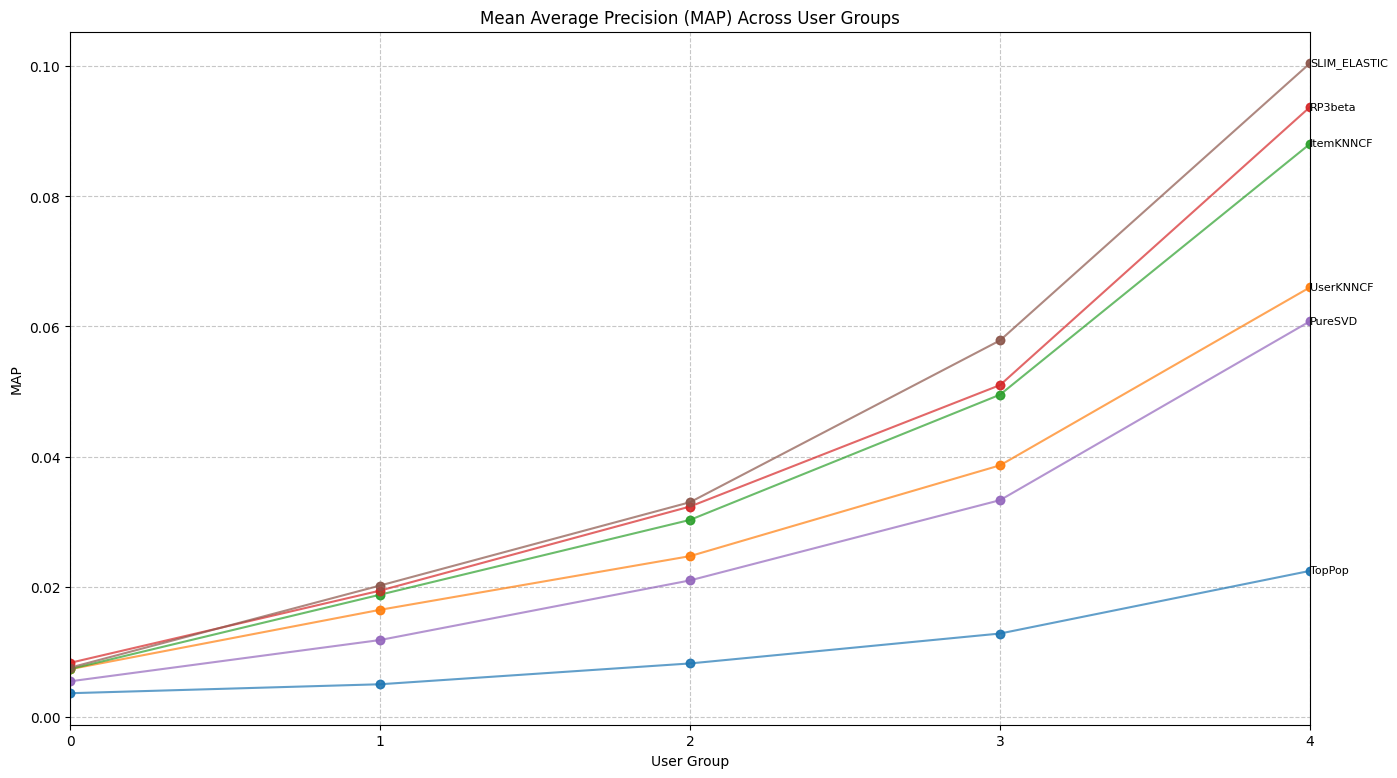

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, 5))

# Set x-axis limits to 0 and 4
plt.xlim(0, 4)

plt.show()

In [ ]:
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
evaluator_test.evaluateRecommender(recommender_object_dict["ItemKNNCF"])